In [1]:
import requests
import pandas as pd

# 台灣證券交易所股票代碼清單下載網址
url = 'https://www.twse.com.tw/exchangeReport/STOCK_DAY_ALL?response=json'

# 使用 requests 套件下載 JSON 格式的資料
response = requests.get(url)
data = response.json()

# 將資料轉換成 DataFrame
df = pd.DataFrame(data['data'], columns=data['fields'])

# 儲存為 CSV 檔案
df.to_csv('stock_list.csv', index=False, encoding='utf-8-sig')

print("台股股票代碼清單已下載並儲存為 stock_list.csv")

台股股票代碼清單已下載並儲存為 stock_list.csv


# FinMind

In [47]:
#特定股票的資訊
import requests
import pandas as pd
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "data_id": "2330",
    "start_date": "2020-01-01",
    "end_date": "2024-12-31",
    "token": "", # 參考登入，獲取金鑰
}
resp = requests.get(url, params=parameter)
data = resp.json()
data = pd.DataFrame(data["data"])
data

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover
0,2020-01-02,2330,33282120,11224165450,332.5,339.0,332.5,339.0,8.0,17160
1,2020-01-03,2330,42023268,14295651580,344.0,345.0,335.5,339.5,0.5,20545
2,2020-01-06,2330,45677057,15210531318,333.0,334.5,332.0,332.0,-7.5,22944
3,2020-01-07,2330,51746181,17053282011,332.5,333.0,326.5,329.5,-2.5,22362
4,2020-01-08,2330,37913748,12484410088,325.0,333.0,325.0,329.5,0.0,18228
...,...,...,...,...,...,...,...,...,...,...
1143,2024-09-16,2330,14456888,13692259575,952.0,952.0,943.0,947.0,0.0,26421
1144,2024-09-18,2330,30094662,28303054525,945.0,948.0,933.0,941.0,-6.0,46622
1145,2024-09-19,2330,35254383,33482773635,940.0,960.0,936.0,960.0,19.0,53494
1146,2024-09-20,2330,66762167,65105344444,981.0,982.0,971.0,973.0,13.0,67911


## 載入必要套件

In [34]:
pip install pycaret

In [48]:
import numpy as np
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
data['short_mavg'] = data['close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
data['long_mavg'] = data['close'].rolling(window=20, min_periods=1, center=False).mean()

# Create signals
data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1.0, 0.0)

In [49]:
data.tail()

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,short_mavg,long_mavg,signal
1143,2024-09-16,2330,14456888,13692259575,952.0,952.0,943.0,947.0,0.0,26421,927.8,935.45,0.0
1144,2024-09-18,2330,30094662,28303054525,945.0,948.0,933.0,941.0,-6.0,46622,935.2,933.85,1.0
1145,2024-09-19,2330,35254383,33482773635,940.0,960.0,936.0,960.0,19.0,53494,947.0,933.95,1.0
1146,2024-09-20,2330,66762167,65105344444,981.0,982.0,971.0,973.0,13.0,67911,953.6,935.05,1.0
1147,2024-09-23,2330,15399658,15013916758,971.0,977.0,971.0,977.0,4.0,26106,959.6,936.45,1.0


## 指標計算

In [50]:
# Calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

data['EMA10'] = EMA(data, 10)
data['EMA30'] = EMA(data, 30)
data['EMA200'] = EMA(data, 200)
data.head()

# Calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

data['ROC10'] = ROC(data['close'], 10)
data['ROC30'] = ROC(data['close'], 30)

# Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

data['MOM10'] = MOM(data['close'], 10)
data['MOM30'] = MOM(data['close'], 30)

# Calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

data['RSI10'] = RSI(data['close'], 10)
data['RSI30'] = RSI(data['close'], 30)
data['RSI200'] = RSI(data['close'], 200)

# Calculation of stochastic oscillator

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

data['%K10'] = STOK(data['close'], data['min'], data['max'], 10)
data['%D10'] = STOD(data['close'], data['min'], data['max'], 10)
data['%K30'] = STOK(data['close'], data['min'], data['max'], 30)
data['%D30'] = STOD(data['close'], data['min'], data['max'], 30)
data['%K200'] = STOK(data['close'], data['min'], data['max'], 200)
data['%D200'] = STOD(data['close'], data['min'], data['max'], 200)

In [51]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
data['MA21'] = MA(data, 10)
data['MA63'] = MA(data, 30)
data['MA252'] = MA(data, 200)
data.tail()

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1143,2024-09-16,2330,14456888,13692259575,952.0,952.0,943.0,947.0,0.0,26421,...,55.302801,88.059701,84.577114,78.102190,79.082844,74.174757,73.721683,918.7,935.100000,790.320
1144,2024-09-18,2330,30094662,28303054525,945.0,948.0,933.0,941.0,-6.0,46622,...,55.148841,79.104478,85.074627,60.000000,73.269836,73.009709,73.786408,918.8,937.133333,792.100
1145,2024-09-19,2330,35254383,33482773635,940.0,960.0,936.0,960.0,19.0,53494,...,55.542739,100.000000,89.054726,81.111111,73.071100,76.699029,74.627832,925.9,938.466667,794.015
1146,2024-09-20,2330,66762167,65105344444,981.0,982.0,971.0,973.0,13.0,67911,...,55.809612,90.109890,89.738123,90.425532,77.178881,79.223301,76.310680,933.0,941.033333,795.990
1147,2024-09-23,2330,15399658,15013916758,971.0,977.0,971.0,977.0,4.0,26106,...,55.891492,94.505495,94.871795,94.680851,88.739165,80.000000,78.640777,938.9,942.466667,798.000


In [52]:
#excluding columns that are not needed for our prediction.

dataset=data.drop(['max','min','open', 'spread','short_mavg','long_mavg','Trading_turnover','stock_id','Trading_money','stock_id','Trading_turnover'], axis=1)

In [53]:
dataset = dataset.dropna(axis=0)

In [54]:
# 將 'date' 列設為索引
dataset.set_index('date', inplace=True)

In [56]:
dataset.to_csv("dataset.csv")

## 資料視覺化

In [57]:
import pandas as pd
dataset = pd.read_csv("dataset.csv", index_col = 'date')
dataset

,Trading_Volume,close,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,,,
2020-11-03,31461727,441.0,0.0,442.342728,441.912274,385.053939,-2.649007,-1.672241,-10.0,-17.0,...,55.040754,43.333333,22.777778,45.454545,34.469697,88.961039,86.868687,444.65,443.133333,354.2850
2020-11-04,37929652,450.0,0.0,443.734959,442.434064,385.797872,-1.098901,1.351351,-3.0,1.5,...,55.441011,73.333333,47.222222,65.909091,48.106061,92.857143,89.466089,444.35,443.183333,354.8750
2020-11-05,36539446,451.0,0.0,445.055876,442.986705,386.543616,-0.221239,2.500000,-4.0,7.0,...,55.485265,76.666667,64.444444,68.181818,59.848485,93.290043,91.702742,443.95,443.416667,355.4825
2020-11-06,32644190,452.5,0.0,446.409353,443.600467,387.296866,0.555556,3.546911,0.5,12.5,...,55.551815,89.090909,79.696970,71.590909,68.560606,93.939394,93.362193,444.00,443.833333,356.0975
2020-11-09,43415670,458.5,1.0,448.607652,444.561728,388.108843,2.572707,5.767013,8.5,21.5,...,55.817355,95.312500,87.023359,85.227273,75.000000,96.536797,94.588745,444.85,444.550000,356.7025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-16,14456888,947.0,0.0,929.207008,935.019643,817.945848,0.744681,7.613636,-1.0,132.0,...,55.302801,88.059701,84.577114,78.102190,79.082844,74.174757,73.721683,918.70,935.100000,790.3200
2024-09-18,30094662,941.0,1.0,931.351188,935.405472,819.170281,5.849269,2.282609,1.0,61.0,...,55.148841,79.104478,85.074627,60.000000,73.269836,73.009709,73.786408,918.80,937.133333,792.1000
2024-09-19,35254383,960.0,1.0,936.560063,936.992216,820.571586,6.430155,7.142857,71.0,40.0,...,55.542739,100.000000,89.054726,81.111111,73.071100,76.699029,74.627832,925.90,938.466667,794.0150


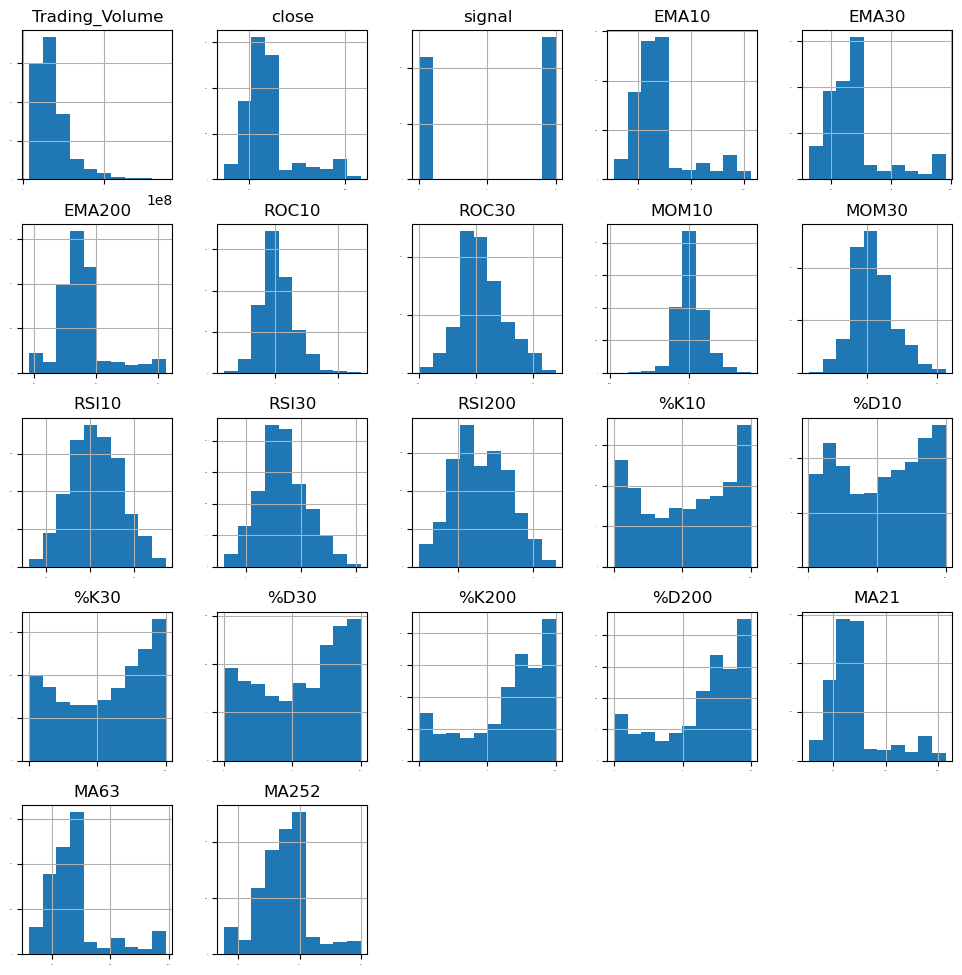

In [58]:
import matplotlib.pyplot as plt

# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

In [60]:
import pandas as pd

stats = dataset.describe()
stats

,Trading_Volume,close,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
count,9.470000e+02,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,...,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,3.696501e+07,600.914467,0.537487,598.506741,593.262213,556.055769,0.862149,2.815497,5.208553,15.800422,...,53.050762,53.243717,53.163069,56.244263,56.177780,65.465915,65.472604,598.471014,593.339880,549.002933
std,2.189085e+07,132.645369,0.498856,129.689646,123.276044,79.968377,5.482804,9.994693,35.114974,58.927476,...,3.668055,33.258747,30.114462,31.663405,30.534606,28.899831,28.770550,130.017191,124.601549,79.998634
min,7.898012e+06,371.000000,0.000000,388.075441,407.798914,385.053939,-15.979381,-24.746450,-190.000000,-166.000000,...,44.794219,0.000000,0.623053,0.000000,0.310078,0.000000,0.141543,384.150000,402.816667,354.285000
25%,2.249007e+07,520.000000,0.000000,519.844737,514.591033,507.068559,-2.700516,-3.881913,-16.000000,-23.000000,...,50.325552,21.052632,23.481380,28.062500,27.811875,49.411765,49.732082,519.150000,519.308333,495.845000
50%,3.129719e+07,578.000000,1.000000,577.241007,577.011462,544.259562,0.307220,1.182432,2.000000,7.000000,...,52.831683,57.142857,56.915532,62.000000,60.830168,74.174757,74.117647,577.400000,577.400000,550.147500
75%,4.409805e+07,612.000000,1.000000,608.711930,602.878308,581.450760,4.087238,8.672378,24.000000,49.000000,...,55.748945,84.615385,81.699339,84.403977,83.932044,88.542893,88.864087,608.900000,604.766667,594.910000
max,1.761660e+08,1080.000000,1.000000,1030.619823,977.606756,823.629729,26.963351,34.939759,158.000000,223.000000,...,62.939763,100.000000,100.000000,100.000000,100.000000,100.000000,99.575372,1037.500000,986.000000,798.000000


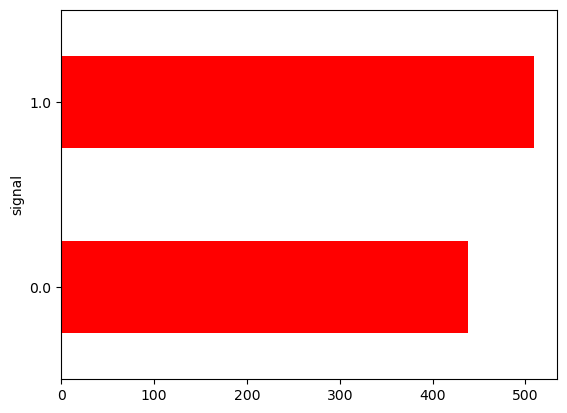

In [61]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

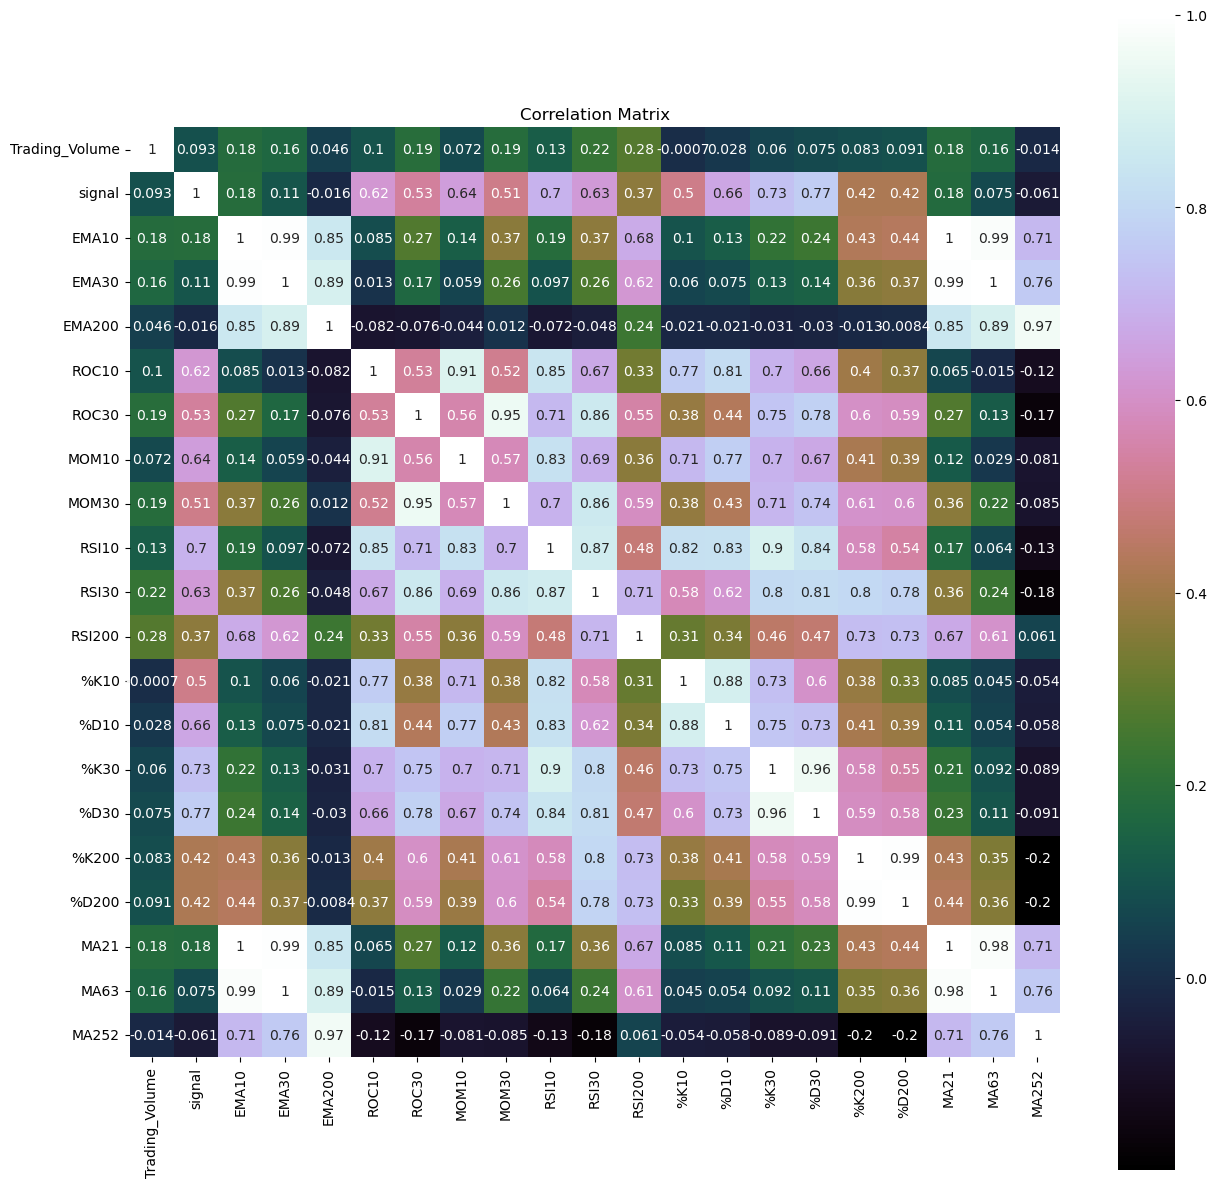

In [17]:
import seaborn as sns  # 導入 Seaborn
import matplotlib.pyplot as plt  # 確保也有導入 Matplotlib

# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

## 模型訓練


In [62]:
# 導入所需的庫
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [20]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
scoring = 'roc_auc'

### 模型

In [21]:
# 導入所需的機器學習模型
from sklearn.linear_model import LogisticRegression  # 邏輯回歸
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # 線性判別分析
from sklearn.neighbors import KNeighborsClassifier  # K 最近鄰
from sklearn.tree import DecisionTreeClassifier  # 決策樹
from sklearn.naive_bayes import GaussianNB  # 高斯朴素貝葉斯
from sklearn.neural_network import MLPClassifier  # 多層感知器（神經網絡）
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier  # 集成模型：AdaBoost、GBM、隨機森林

In [22]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [23]:
from sklearn.model_selection import KFold, cross_val_score  # 導入 KFold 和交叉驗證函數

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.916882 (0.042271)
LDA: 0.974236 (0.013211)
KNN: 0.516782 (0.047537)
CART: 0.871877 (0.034069)
NB: 0.663655 (0.070292)
NN: 0.500000 (0.000000)


C:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\886

AB: 0.971787 (0.016839)
GBM: 0.978301 (0.014356)
RF: 0.975722 (0.014295)


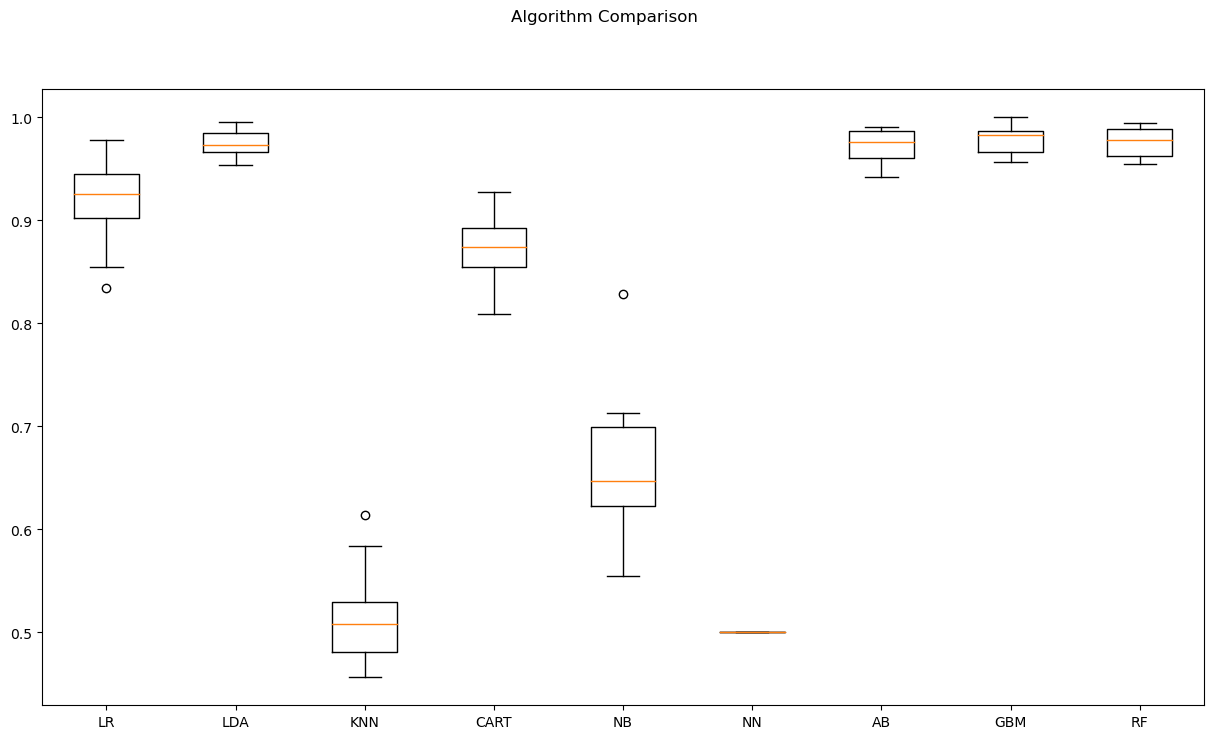

In [24]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## 參數優化

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

# 定義數據標準化 (可選)
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)

# 設定GBM的參數範圍
n_estimators = [50, 100, 200]  # 樹的數量
learning_rate = [0.01, 0.1, 0.2]  # 學習率
max_depth = [3, 5, 10]  # 樹的深度
subsample = [0.7, 0.8, 1.0]  # 子樣本比例

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, 
                  max_depth=max_depth, subsample=subsample)

# 設置GBM模型
model = GradientBoostingClassifier()

# 設置K-fold交叉驗證
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# 設置Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# 打印最佳結果
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 打印每個參數組合的詳細結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))


Best: 0.983996 using {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
#69 0.961465 (0.019858) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
#68 0.962230 (0.021929) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
#71 0.959567 (0.020208) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
#66 0.964014 (0.019188) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
#65 0.964388 (0.019273) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
#67 0.963098 (0.018979) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
#58 0.968759 (0.018627) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
#59 0.968363 (0.018102) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
#57 0.968824 (0.017945) with: {'

## 最終模型

In [26]:
# prepare model
model = GradientBoostingClassifier(learning_rate= 0.2, max_depth= 3, n_estimators= 200, subsample = 0.8) 
model.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=200, subsample=0.8)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9473684210526315
[[85  6]
 [ 4 95]]
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94        91
         1.0       0.94      0.96      0.95        99

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190



<Axes: xlabel='Predicted', ylabel='Actual'>

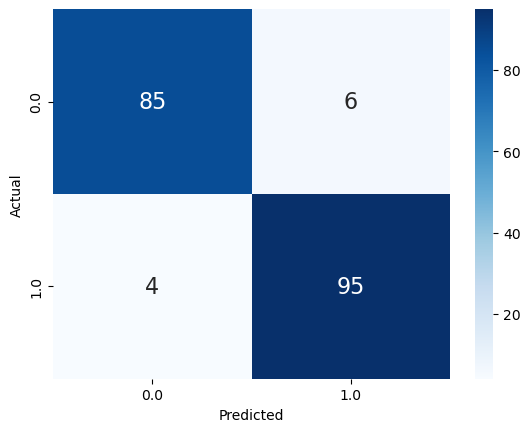

In [28]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

## 特徵重要度分析

Text(0.5, 0, 'Variable Importance')

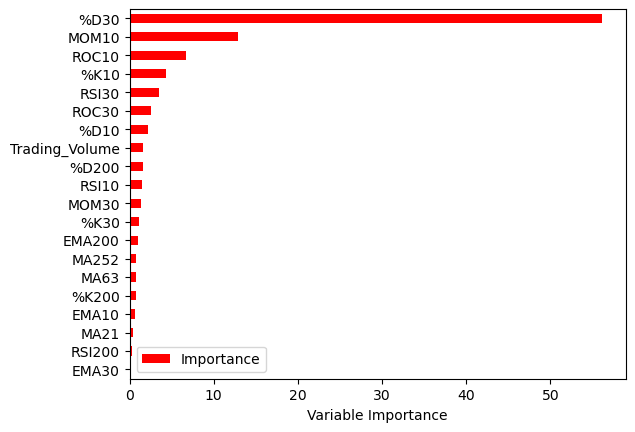

In [29]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

## 回測

<Axes: >

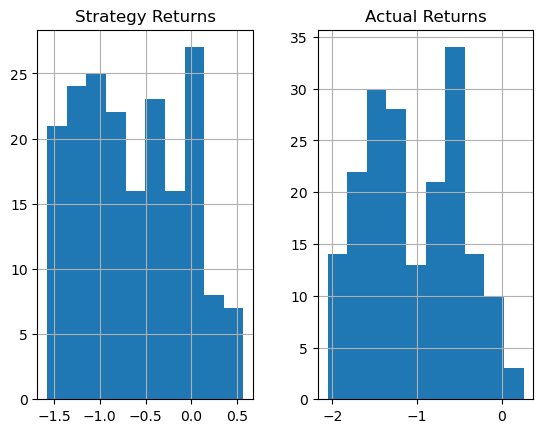

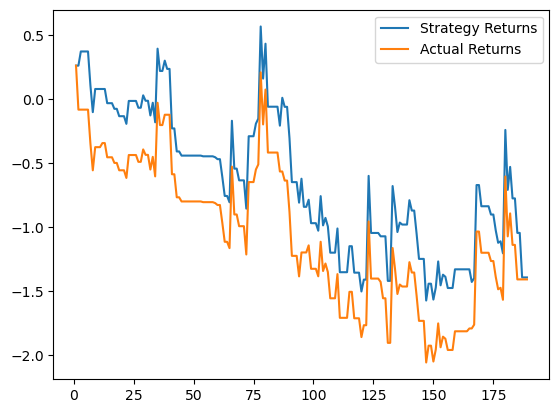

In [63]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()